## Set up Hamiltonian Monte Carlo (HMC) pipeline

In [58]:
## Can comment the first two lines if C++ backend works fine
import os
os.environ["PYTENSOR_FLAGS"] = "mode=FAST_RUN,optimizer=fast_compile"

import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

In [65]:
## Uncomment all the below lines if C++ backend works fine
#import platform

#print("Python platform:", platform.platform())
#print("PyMC version:", pm.__version__)

In [59]:
# Simulate synthetic market data
def simulate_liquidity_data(T=100, seed=0):
    np.random.seed(seed)
    true_liq_stress = np.zeros(T)
    for t in range(1, T):
        true_liq_stress[t] = true_liq_stress[t-1] + 0.2 * np.random.normal()

    spread = 0.5 + 0.3 * true_liq_stress + 0.2 * np.random.normal(size=T)
    volatility = 0.7 + 0.5 * true_liq_stress + 0.3 * np.random.normal(size=T)

    return pd.DataFrame({
        'time': np.arange(T),
        'spread': spread,
        'volatility': volatility,
        'true_liq_stress': true_liq_stress
    })

/Users/keduseworku/miniforge3/envs/pymc_arm/lib/python3.10/site-packages/pymc/distributions/timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [liq_stress, alpha_spread, beta_spread, sigma_spread, alpha_vol, beta_vol, sigma_vol]
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor 

/Users/keduseworku/miniforge3/envs/pymc_arm/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1307 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_dataarray()` method.

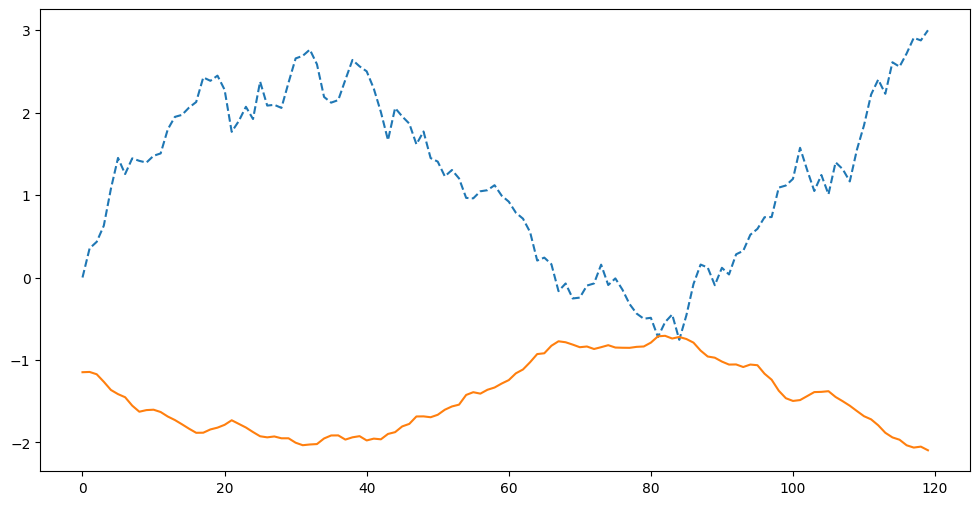

In [3]:
# Main cell for running HMM model through PyMC
if __name__ == "__main__":
    df = simulate_liquidity_data(T=120)
    spread_obs = df['spread'].values
    vol_obs = df['volatility'].values
    T = len(spread_obs)

    with pm.Model() as model:
        liq_stress = pm.GaussianRandomWalk("liq_stress", sigma=0.2, shape=T)

        alpha_spread = pm.Normal("alpha_spread", mu=0, sigma=1)
        beta_spread = pm.Normal("beta_spread", mu=0, sigma=1)
        sigma_spread = pm.Exponential("sigma_spread", lam=1.0)

        alpha_vol = pm.Normal("alpha_vol", mu=0, sigma=1)
        beta_vol = pm.Normal("beta_vol", mu=0, sigma=1)
        sigma_vol = pm.Exponential("sigma_vol", lam=1.0)

        mu_spread = alpha_spread + beta_spread * liq_stress
        mu_vol = alpha_vol + beta_vol * liq_stress

        spread_like = pm.Normal("obs_spread", mu=mu_spread, sigma=sigma_spread, observed=spread_obs)
        vol_like = pm.Normal("obs_vol", mu=mu_vol, sigma=sigma_vol, observed=vol_obs)

        trace = pm.sample(1000, tune=500, target_accept=0.9, return_inferencedata=True)

    # Posterior mean and intervals
    liq_stress_mean = trace.posterior['liq_stress'].mean(dim=["chain", "draw"])
    liq_stress_hpd = az.hdi(trace.posterior['liq_stress'], hdi_prob=0.95)

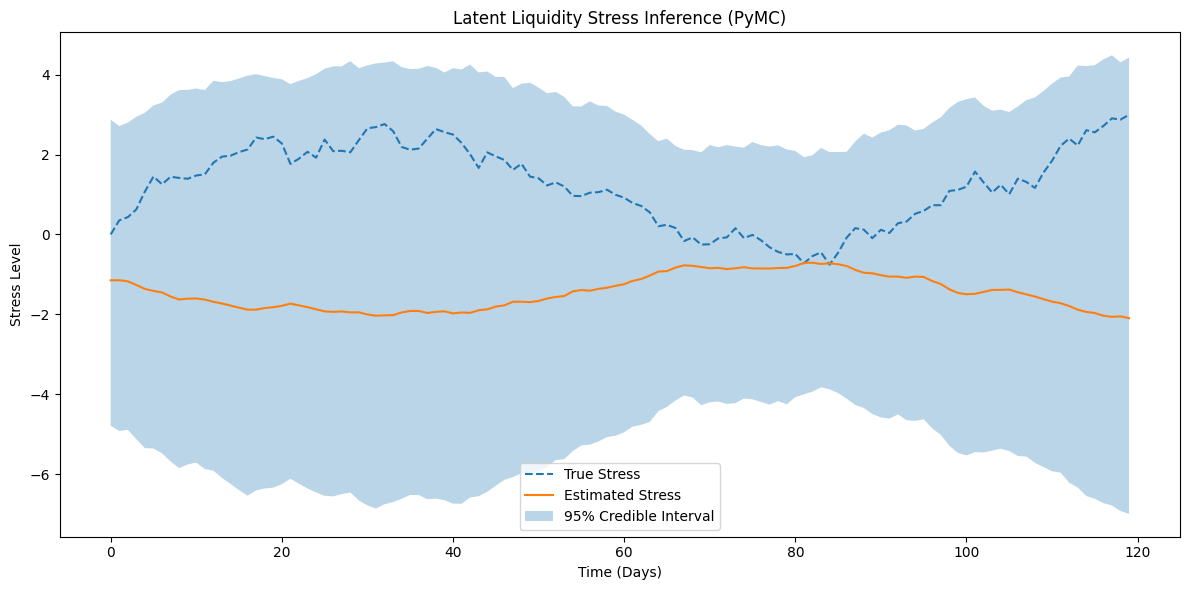

In [60]:
# Let's plot results! 
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['true_liq_stress'], label='True Stress', linestyle='--')
plt.plot(df['time'], liq_stress_mean, label='Estimated Stress')
plt.fill_between(
    df['time'],
    liq_stress_hpd.sel(hdi='lower').to_array().squeeze(),
    liq_stress_hpd.sel(hdi='higher').to_array().squeeze(),
    alpha=0.3,
    label='95% Credible Interval'
)
plt.title("Latent Liquidity Stress Inference (PyMC)")

plt.xlabel("Time (Days)")
plt.ylabel("Stress Level")
plt.legend()
plt.tight_layout()
plt.savefig('save_plot.png')
plt.show()

In [61]:
## Improving the plot
stress_post = trace.posterior['liq_stress']

# 90% HDI
hdi_90 = az.hdi(stress_post, hdi_prob=0.90)

# 50% HDI
hdi_50 = az.hdi(stress_post, hdi_prob=0.50)

# Mean estimate
stress_mean = stress_post.mean(dim=["chain", "draw"])

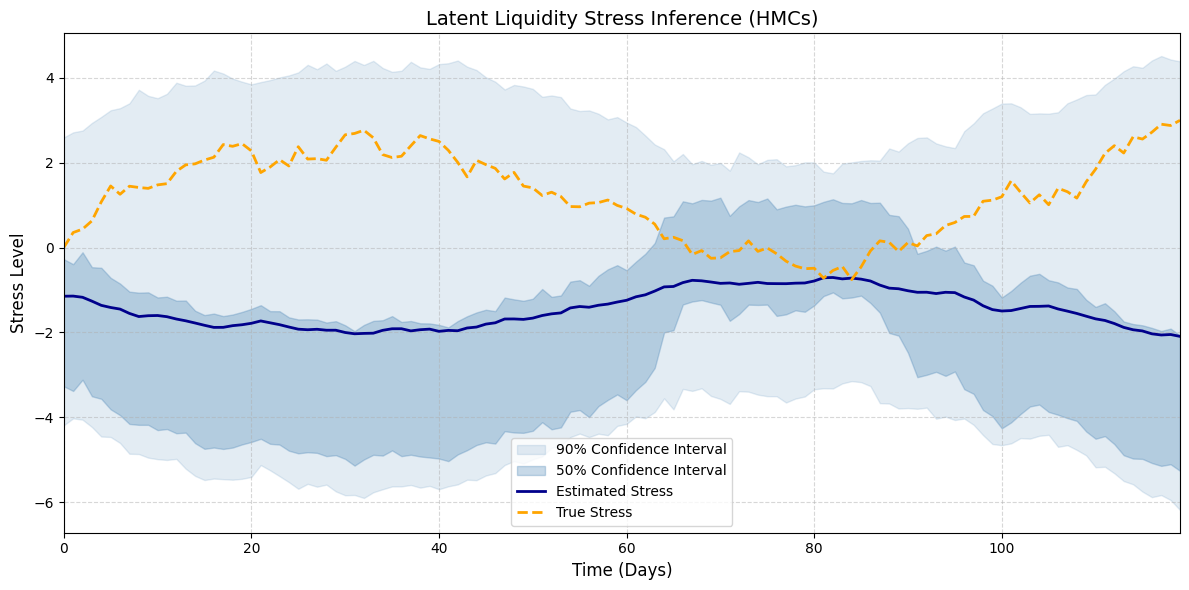

In [63]:
## Improving the plot
plt.figure(figsize=(12, 6))

## 90% confidence intervals (CI)
plt.fill_between(
    df['time'],
    hdi_90.sel(hdi='lower').to_array().squeeze(),
    hdi_90.sel(hdi='higher').to_array().squeeze(),
    color='steelblue',
    alpha=0.15,
    label='90% Confidence Interval'
)

## 50% confidence intervals (CI, darker inside band)
plt.fill_between(
    df['time'],
    hdi_50.sel(hdi='lower').to_array().squeeze(),
    hdi_50.sel(hdi='higher').to_array().squeeze(),
    color='steelblue',
    alpha=0.3,
    label='50% Confidence Interval'
)

## Posterior mean
plt.plot(df['time'], stress_mean, label='Estimated Stress', color='darkblue', linewidth=2)

## 'True' latent series
plt.plot(df['time'], df['true_liq_stress'], label='True Stress', linestyle='--', color='orange', linewidth=2)

## With PyMC
plt.title("Latent Liquidity Stress Inference (HMCs)", fontsize=14)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Stress Level", fontsize=12)
plt.xlim(0, 119)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('save_plot.png')
plt.show()

## Set up Hidden Markov model (HMM) pipeline

In [68]:
from hmmlearn import hmm

# Copy simulated data
obs = np.column_stack((df['spread'].values, df['volatility'].values))

# Fit HMM with 2 hidden states (calm vs stressed)
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=200, random_state=42)
model.fit(obs)
z_inferred = model.predict(obs)

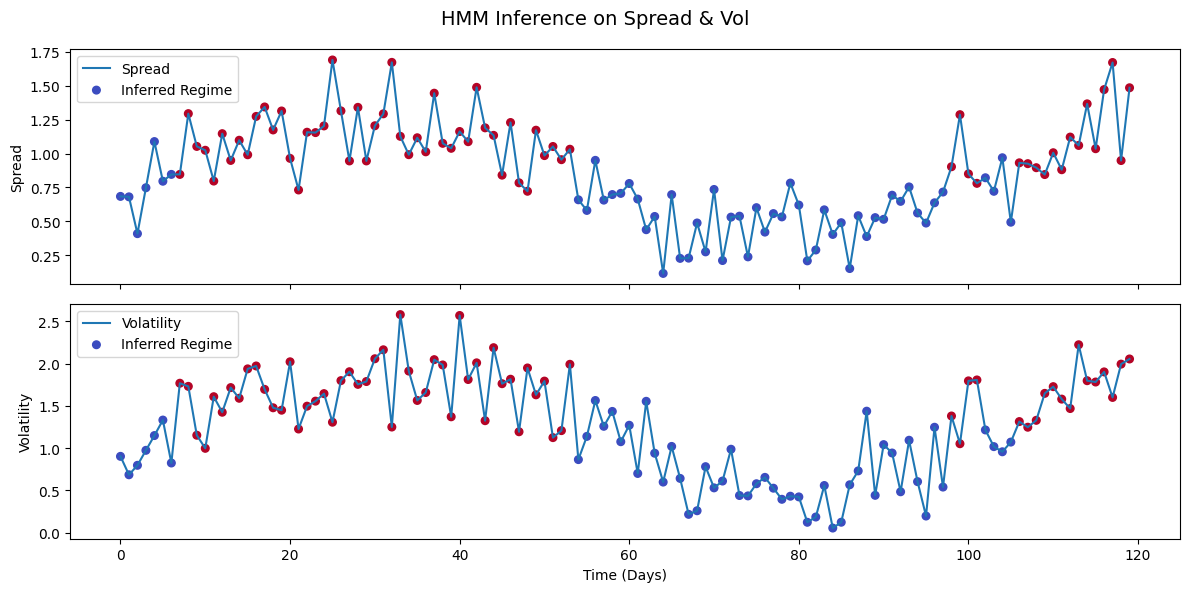

In [69]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(df['time'], df['spread'], label='Spread', linewidth=1.5)
ax[0].scatter(df['time'], df['spread'], c=z_inferred, cmap='coolwarm', s=30, label='Inferred Regime')
ax[0].set_ylabel("Spread")
ax[0].legend()

ax[1].plot(df['time'], df['volatility'], label='Volatility', linewidth=1.5)
ax[1].scatter(df['time'], df['volatility'], c=z_inferred, cmap='coolwarm', s=30, label='Inferred Regime')
ax[1].set_ylabel("Volatility")
ax[1].set_xlabel("Time (Days)")
ax[1].legend()

plt.suptitle("HMM Inference on Spread & Vol", fontsize=14)
plt.tight_layout()
plt.savefig('save_plot.png')
plt.show()

## Model Comparisons

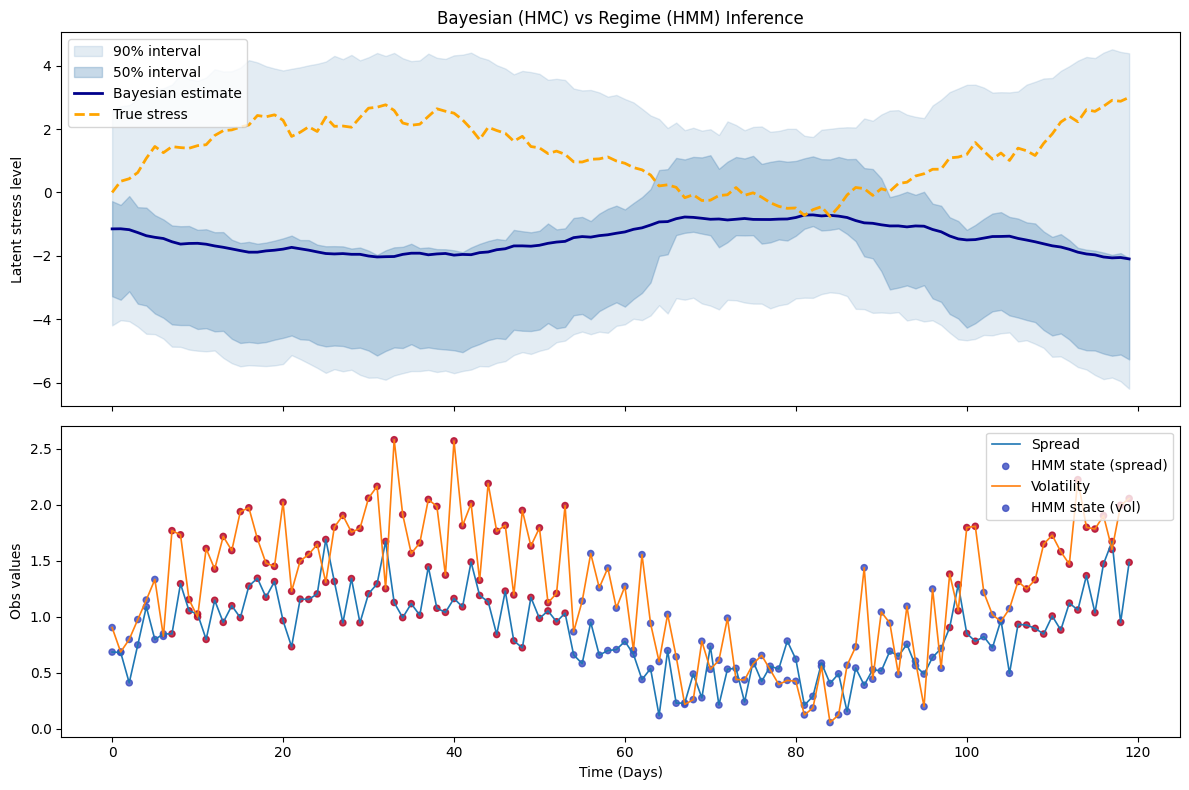

In [52]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [1.2, 1]})

# HMC Posteriors + Bands
axs[0].fill_between(
    df["time"],
    hdi_90.sel(hdi='lower').to_array().squeeze(),
    hdi_90.sel(hdi='higher').to_array().squeeze(),
    color='steelblue', alpha=0.15, label='90% interval'
)
axs[0].fill_between(
    df["time"],
    hdi_50.sel(hdi='lower').to_array().squeeze(),
    hdi_50.sel(hdi='higher').to_array().squeeze(),
    color='steelblue', alpha=0.3, label='50% interval'
)
axs[0].plot(df["time"], stress_mean, color='darkblue', linewidth=2, label='Bayesian estimate')
axs[0].plot(df["time"], df["true_liq_stress"], '--', color='orange', linewidth=2, label='True stress')
axs[0].set_ylabel("Latent stress level")
axs[0].legend(loc="upper left")
axs[0].set_title("Bayesian (HMC) vs Regime (HMM) Inference")

# HMM Regimes
axs[1].plot(df["time"], df["spread"], label="Spread", linewidth=1.2)
axs[1].scatter(df["time"], df["spread"], c=z_inferred, cmap="coolwarm", s=20, label="HMM state (spread)", alpha=0.8)
axs[1].plot(df["time"], df["volatility"], label="Volatility", linewidth=1.2)
axs[1].scatter(df["time"], df["volatility"], c=z_inferred, cmap="coolwarm", s=20, label="HMM state (vol)", alpha=0.8)
axs[1].set_xlabel("Time (Days)")
axs[1].set_ylabel("Obs values")
axs[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

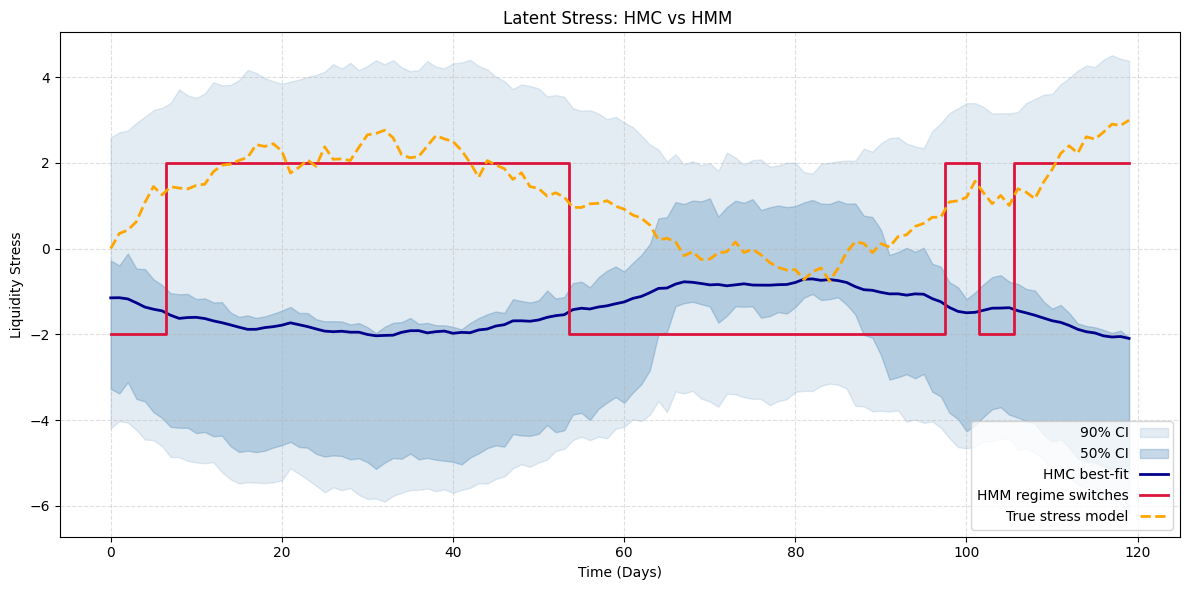

In [70]:
plt.figure(figsize=(12, 6))

# Avg HMM regimes to vals akin to stress 
state_to_stress = {0: -2.0, 1: 2.0}
pseudo_stress = np.array([state_to_stress[z] for z in z_inferred])

# HMC posterior bands
plt.fill_between(df["time"], hdi_90.sel(hdi='lower').to_array().squeeze(),
                 hdi_90.sel(hdi='higher').to_array().squeeze(),
                 color='steelblue', alpha=0.15, label='90% CI')

plt.fill_between(df["time"], hdi_50.sel(hdi='lower').to_array().squeeze(),
                 hdi_50.sel(hdi='higher').to_array().squeeze(),
                 color='steelblue', alpha=0.3, label='50% CI')

# HMC posterior
plt.plot(df["time"], stress_mean, color='darkblue', linewidth=2, label='HMC best-fit')

# HMM states
plt.step(df["time"], pseudo_stress, where='mid', color='crimson', linewidth=2, label='HMM regime switches')

# 'true' model
plt.plot(df["time"], df["true_liq_stress"], '--', color='orange', linewidth=2, label='True stress model')

plt.title("Latent Stress: HMC vs HMM ")
plt.xlabel("Time (Days)")
plt.ylabel("Liquidity Stress")
plt.legend(loc = 4, markerfirst = False)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('sample_plot.png')
plt.show()